In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Carga de archivos

try:
    df_clientes = pd.read_csv(r"Base de datos/Clientes.csv")
    df_productos = pd.read_csv(r"Base de datos/Productos.csv")
    df_ventas = pd.read_csv(r"Base de datos/Ventas.csv")
    df_detalle = pd.read_csv(r"Base de datos/Detalle_ventas.csv")
    
    print("Datos cargados exitosamente:")
    print(f"Clientes: {df_clientes.shape}")
    print(f"Productos: {df_productos.shape}")
    print(f"Ventas: {df_ventas.shape}")
    print(f"Detalle Ventas: {df_detalle.shape}")
    
except FileNotFoundError as e:
    print(f"Error: No se encontró el archivo. {e}")

Datos cargados exitosamente:
Clientes: (576, 5)
Productos: (100, 6)
Ventas: (19084, 6)
Detalle Ventas: (34775, 7)


In [3]:
# Limpieza: Clientes

df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'])
df_clientes = df_clientes.drop_duplicates(subset=['id_cliente'], keep='first')
df_clientes['email'] = df_clientes['email'].fillna('desconocido@mail.com')
df_clientes['ciudad'] = df_clientes['ciudad'].fillna('Desconocida')

print(df_clientes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_cliente      576 non-null    int64         
 1   nombre_cliente  576 non-null    object        
 2   email           576 non-null    object        
 3   ciudad          576 non-null    object        
 4   fecha_alta      576 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 22.6+ KB
None


In [4]:
# Limpieza: Productos

df_productos['precio_unitario'] = pd.to_numeric(df_productos['precio_unitario'], errors='coerce')
df_productos = df_productos.drop_duplicates(subset=['id_producto'], keep='first')
df_productos = df_productos.dropna(subset=['precio_unitario'])

print(df_productos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id_producto      100 non-null    int64 
 1   nombre_producto  100 non-null    object
 2   categoria        100 non-null    object
 3   precio_unitario  100 non-null    int64 
 4   score_pop        100 non-null    int64 
 5   popularidad      100 non-null    object
dtypes: int64(3), object(3)
memory usage: 4.8+ KB
None


In [5]:
# Limpieza: Ventas

df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
df_ventas = df_ventas.drop_duplicates(subset=['id_venta'], keep='first')

# Eliminamos columnas redundantes identificadas en el README.md
df_ventas = df_ventas.drop(columns=['nombre_cliente', 'email'])
df_ventas = df_ventas.dropna(subset=['id_cliente', 'fecha'])
df_ventas['id_cliente'] = df_ventas['id_cliente'].astype(int)

print(df_ventas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id_venta    19084 non-null  int64         
 1   id_cliente  19084 non-null  int32         
 2   fecha       19084 non-null  datetime64[ns]
 3   medio_pago  19084 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 522.0+ KB
None


In [7]:
# Limpieza: Detalle_ventas

# Eliminamos columna redundante
df_detalle = df_detalle.drop(columns=['nombre_producto'])

df_detalle['cantidad'] = pd.to_numeric(df_detalle['cantidad'], errors='coerce')
df_detalle['precio_unitario'] = pd.to_numeric(df_detalle['precio_unitario'], errors='coerce')
df_detalle['importe'] = pd.to_numeric(df_detalle['importe'], errors='coerce')

# Una venta sin importe o cantidad no sirve
df_detalle = df_detalle.dropna(subset=['id_venta', 'id_producto', 'importe', 'cantidad'])

print(df_detalle.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id_venta         343 non-null    int64
 1   id_producto      343 non-null    int64
 2   cantidad         343 non-null    int64
 3   precio_unitario  343 non-null    int64
 4   importe          343 non-null    int64
dtypes: int64(5)
memory usage: 13.5 KB
None


In [6]:
# Integridad Referencial

# 1. Ventas -> Clientes
clientes_validos = df_clientes['id_cliente'].unique()
ventas_invalidas = df_ventas[~df_ventas['id_cliente'].isin(clientes_validos)].shape[0]
print(f"Ventas con id_cliente 'huérfano': {ventas_invalidas}")
if ventas_invalidas > 0:
    df_ventas = df_ventas[df_ventas['id_cliente'].isin(clientes_validos)]

# 2. Detalle_ventas -> Ventas
ventas_validas = df_ventas['id_venta'].unique()
detalles_invalidos = df_detalle[~df_detalle['id_venta'].isin(ventas_validas)].shape[0]
print(f"Detalles con id_venta 'huérfano': {detalles_invalidos}")
if detalles_invalidos > 0:
    df_detalle = df_detalle[df_detalle['id_venta'].isin(ventas_validas)]
    
print("Verificación de integridad completada. Datos huérfanos eliminados.")

Ventas con id_cliente 'huérfano': 0
Detalles con id_venta 'huérfano': 0
Verificación de integridad completada. Datos huérfanos eliminados.


In [7]:
# Preparación de Base RFM

# 1. Calcular el valor monetario (M) por cada VENTA
df_ventas_monetario = df_detalle.groupby('id_venta')['importe'].sum().reset_index()
df_ventas_monetario = df_ventas_monetario.rename(columns={'importe': 'total_venta'})

# 2. Unir la tabla de Ventas (R y F) con la tabla de Monetario (M)
df_rfm_base = pd.merge(
    df_ventas,
    df_ventas_monetario,
    on='id_venta',
    how='inner' # Solo nos quedamos con ventas que tuvieron detalle
)

# 3. Seleccionar las columnas finales necesarias
df_rfm_base = df_rfm_base[['id_cliente', 'fecha', 'id_venta', 'total_venta']]

print(df_rfm_base.head())

# 4. Guardar la base limpia
df_rfm_base.to_csv(r'Base de datos/rfm_base_limpia.csv', index=False)

   id_cliente               fecha  id_venta  total_venta
0         327 2023-01-04 05:00:00         2       2032.0
1         462 2023-01-05 07:00:00         3      12548.0
2         534 2023-01-06 12:00:00         4       5459.0
3         365 2023-01-06 18:59:00         5       1723.0
4         287 2023-01-09 00:00:00         6       1856.0


### Creación de RFM

In [8]:
# Cálculo de R, F y M por Cliente

# 1. Cargar la base de transacciones que limpiamos
try:
    df_base = pd.read_csv(r"Base de datos/rfm_base_limpia.csv")
    df_base['fecha'] = pd.to_datetime(df_base['fecha'])
except FileNotFoundError:
    print("Error: No se encontró 'rfm_base_limpia.csv'.")
    print("Asegúrate de ejecutar las celdas anteriores primero.")

# 2. Definir la fecha de "hoy" (snapshot)
# Usamos un día después de la última venta para que sea reproducible
snapshot_date = df_base['fecha'].max() + pd.Timedelta(days=1)
print(f"Fecha del snapshot (para calcular Recencia): {snapshot_date.date()}")

# 3. Calcular R, F y M
df_rfm = df_base.groupby('id_cliente').agg(
    Recencia=('fecha', lambda x: (snapshot_date - x.max()).days),
    Frecuencia=('id_venta', 'count'),
    Monetario=('total_venta', 'sum')
).reset_index()

print("\nTabla RFM por cliente")
print(df_rfm.head())

# Asegurarse de que los tipos de datos son correctos
df_rfm['Recencia'] = df_rfm['Recencia'].astype(int)
df_rfm['Frecuencia'] = df_rfm['Frecuencia'].astype(int)
df_rfm['Monetario'] = df_rfm['Monetario'].astype(float)

Fecha del snapshot (para calcular Recencia): 2024-11-01

Tabla RFM por cliente
   id_cliente  Recencia  Frecuencia  Monetario
0           1        89           5    67886.0
1           2        18          14   103594.0
2           3         4          69   602345.0
3           4       329           1     4864.0
4           5       162           1    12565.0


In [9]:
# 1. Estadísticas Básicas

print("--- Estadísticas Descriptivas de RFM ---")
# .describe() nos da la media, mediana (50%), min, max, y cuartiles
print(df_rfm[['Recencia', 'Frecuencia', 'Monetario']].describe())

--- Estadísticas Descriptivas de RFM ---
         Recencia  Frecuencia     Monetario
count  559.000000  559.000000  5.590000e+02
mean    82.155635   28.747764  1.986808e+05
std    149.249169   46.598903  3.235765e+05
min      1.000000    1.000000  5.800000e+02
25%      7.000000    3.000000  1.862350e+04
50%     21.000000    9.000000  6.762600e+04
75%     70.500000   26.000000  1.953115e+05
max    666.000000  293.000000  2.444975e+06


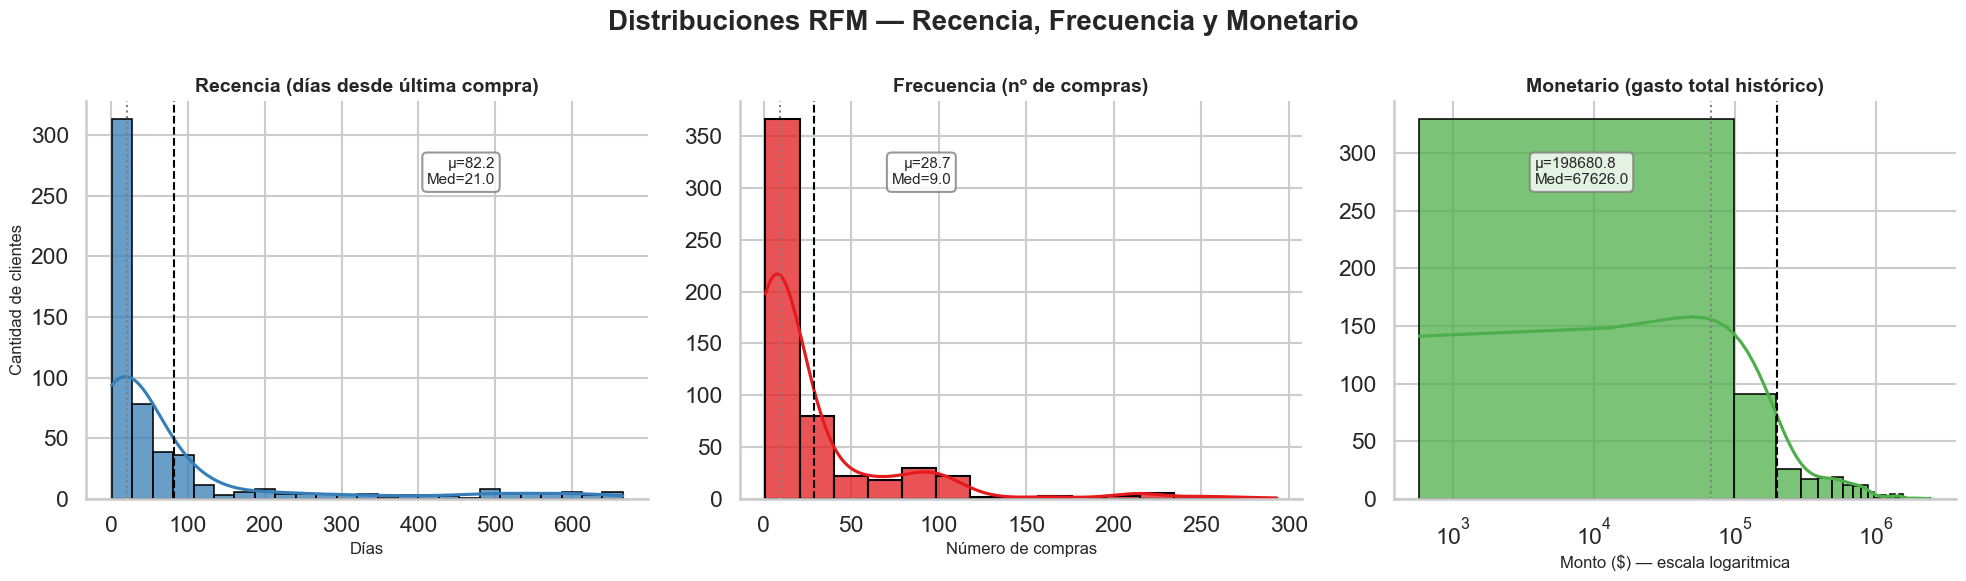

In [10]:
# Histograma RFM

sns.set_style("whitegrid")
sns.set_context("talk")
palette = ['#377eb8', '#e41a1c', '#4daf4a']  # azul, rojo, verde
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribuciones RFM — Recencia, Frecuencia y Monetario', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.88, wspace=0.3)

# Helper para dibujar media/mediana
def _annotate_stats(ax, data, xpos='right'):
    mean = data.mean()
    median = data.median()
    ymax = ax.get_ylim()[1]
    ax.axvline(mean, color='k', linestyle='--', linewidth=1.5, label=f"Media: {mean:.1f}")
    ax.axvline(median, color='gray', linestyle=':', linewidth=1.5, label=f"Mediana: {median:.1f}")
    # Anotaciones
    x_text = data.quantile(0.95) if xpos == 'right' else data.quantile(0.05)
    ax.text(x_text, ymax*0.82, f"μ={mean:.1f}\nMed={median:.1f}", 
            ha='right' if xpos == 'right' else 'left', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8), fontsize=11)

# Recencia
sns.histplot(df_rfm['Recencia'], bins=25, kde=True, color=palette[0], alpha=0.75, edgecolor='k', ax=axes[0])
axes[0].set_title('Recencia (días desde última compra)', fontsize=14, weight='semibold')
axes[0].set_xlabel('Días', fontsize=12)
axes[0].set_ylabel('Cantidad de clientes', fontsize=12)
_annotate_stats(axes[0], df_rfm['Recencia'], xpos='right')
sns.despine(ax=axes[0])

# Frecuencia
sns.histplot(df_rfm['Frecuencia'], bins=15, kde=True, color=palette[1], alpha=0.75, edgecolor='k', ax=axes[1])
axes[1].set_title('Frecuencia (nº de compras)', fontsize=14, weight='semibold')
axes[1].set_xlabel('Número de compras', fontsize=12)
axes[1].set_ylabel('')
_annotate_stats(axes[1], df_rfm['Frecuencia'], xpos='right')
sns.despine(ax=axes[1])

# Monetario (escala log para facilitar interpretación si hay sesgo)
sns.histplot(df_rfm['Monetario'], bins=25, kde=True, color=palette[2], alpha=0.75, edgecolor='k', ax=axes[2])
axes[2].set_title('Monetario (gasto total histórico)', fontsize=14, weight='semibold')
axes[2].set_xlabel('Monto ($)', fontsize=12)
axes[2].set_ylabel('')
# Usar escala log si la distribución está muy sesgada
try:
    axes[2].set_xscale('log')
    axes[2].set_xlabel('Monto ($) — escala logaritmica', fontsize=12)
except Exception:
    pass
_annotate_stats(axes[2], df_rfm['Monetario'], xpos='left')
sns.despine(ax=axes[2])

plt.tight_layout()
plt.show()

--- Matriz de Correlación RFM ---
            Recencia  Frecuencia  Monetario
Recencia    1.000000   -0.283550  -0.281101
Frecuencia -0.283550    1.000000   0.975872
Monetario  -0.281101    0.975872   1.000000


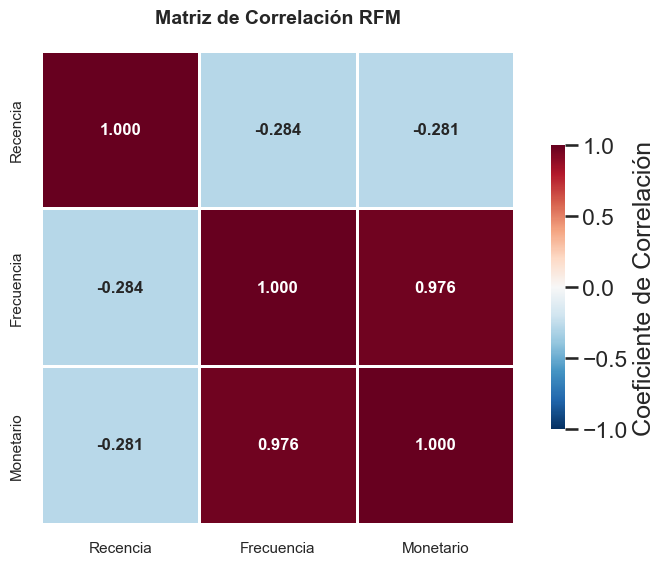

In [11]:
# 3. Correlaciones

# Calcular la matriz de correlación
corr_matrix = df_rfm[['Recencia', 'Frecuencia', 'Monetario']].corr()

print("--- Matriz de Correlación RFM ---")
print(corr_matrix)

# Visualizar la matriz con un mapa de calor más compacto
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".3f",
            linewidths=1, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': 0.6, 'label': 'Coeficiente de Correlación'},
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Matriz de Correlación RFM', fontsize=14, fontweight='bold', pad=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


--- Visualización de Outliers (Boxplots) ---


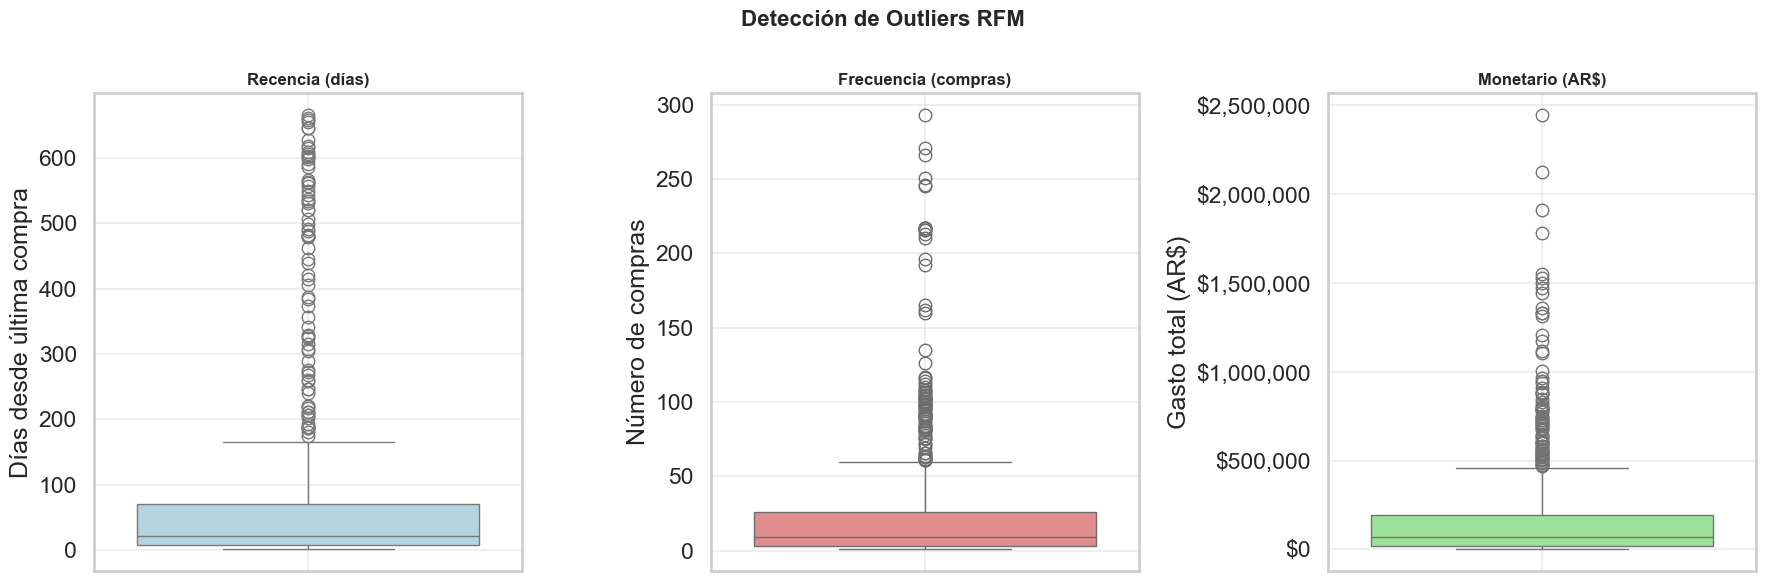


--- Estadísticas de Outliers ---
Recencia: 77 outliers detectados
Frecuencia: 89 outliers detectados
Monetario: 82 outliers detectados


In [12]:
# 4. Análisis de Outliers
print("\n--- Visualización de Outliers (Boxplots) ---")

# Crear una figura con 3 sub-gráficos con mejor estilo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Detección de Outliers RFM', fontsize=16, fontweight='bold')

# Boxplot de Recencia
sns.boxplot(y=df_rfm['Recencia'], ax=axes[0], color='lightblue')
axes[0].set_title('Recencia (días)', fontsize=12, fontweight='semibold')
axes[0].set_ylabel('Días desde última compra')
axes[0].grid(True, alpha=0.3)

# Boxplot de Frecuencia  
sns.boxplot(y=df_rfm['Frecuencia'], ax=axes[1], color='lightcoral')
axes[1].set_title('Frecuencia (compras)', fontsize=12, fontweight='semibold')
axes[1].set_ylabel('Número de compras')
axes[1].grid(True, alpha=0.3)

# Boxplot de Monetario
sns.boxplot(y=df_rfm['Monetario'], ax=axes[2], color='lightgreen')
axes[2].set_title('Monetario (AR$)', fontsize=12, fontweight='semibold')
axes[2].set_ylabel('Gasto total (AR$)')
axes[2].grid(True, alpha=0.3)

# Formatear eje Y del monetario
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Mostrar estadísticas de outliers
print("\n--- Estadísticas de Outliers ---")
for col in ['Recencia', 'Frecuencia', 'Monetario']:
    Q1 = df_rfm[col].quantile(0.25)
    Q3 = df_rfm[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_rfm[(df_rfm[col] < Q1 - 1.5*IQR) | (df_rfm[col] > Q3 + 1.5*IQR)][col]
    print(f"{col}: {len(outliers)} outliers detectados")